<a href="https://colab.research.google.com/github/LavanyaShivamurthy/myCoLabLearing/blob/main/myMultiTaskModel_MTNN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [3]:
low_memory = False

In [4]:
file_path= '/content/drive/MyDrive/DataSets/ICUMonitoring.csv'

In [5]:
    #def preprocess_network_data(file_path, low_memory=False):
    #classication for 3 class
    """
    Load and preprocess network packet data with Eisenhower Matrix prioritization:
    - Emergency and Important (Critical)
    - Emergency but Not Important (Urgent)
    - Not Emergency but Important (Important) # can delete thsis
    - Not Emergency and Not Important (Routine)

    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing network packet data
    low_memory : bool
        Whether to use low_memory mode for pandas read_csv

    Returns:
    --------
    pd.DataFrame
        Preprocessed network data with derived features and priority classifications
    """
    df = pd.read_csv(file_path, low_memory=low_memory,dtype={'frame.time_delta':'float64','frame.len':'float64',   # Add explicit dtypes for columns with mixed types
      # Adjust column numbers based on your data
      26:'object',
      28:'object',
      35:'object'})
    # NEW: Detailed missing value analysis
    missing_stats = {}

    # Column-level missing value analysis
    missing_stats['columns'] = {}
    missing_cols = df.columns[df.isnull().any()].tolist()

    print(f"Original dataset shape: {df.shape}")
    print(f"Total missing values: {df.isnull().sum().sum()}")
    print(f"Columns with missing values: {len(missing_cols)} out of {len(df.columns)}")

    # Detailed report for columns with missing values
    print("\nMissing value analysis by column:")
    for col in missing_cols:
        missing_count = df[col].isnull().sum()
        missing_percent = (missing_count / len(df)) * 100
        missing_stats['columns'][col] = {
            'count': int(missing_count),
            'percent': float(missing_percent)
        }
        print(f"  - {col}: {missing_count} values ({missing_percent:.2f}%)")

     # Row-level missing value analysis
    missing_counts_per_row = df.isnull().sum(axis=1)
    rows_with_missing = (missing_counts_per_row > 0).sum()
    missing_stats['rows'] = {
        'total_rows_with_missing': int(rows_with_missing),
        'percent_rows_with_missing': float((rows_with_missing / len(df)) * 100),
        'distribution': {}
     }

     # Distribution of missing values per row
    value_counts = missing_counts_per_row.value_counts().sort_index()

    print("\nMissing value analysis by row:")
    print(f"Rows with at least one missing value: {rows_with_missing} out of {len(df)} ({(rows_with_missing/len(df))*100:.2f}%)")
    print("\nDistribution of missing values per row:")
    missing_stats['rows']['distribution'] = {}
    percent=0.0
    for count, frequency in value_counts.items():
        if count > 0:  # Only show rows that have missing values
            percent = (frequency / len(df)) * 100
            missing_stats['rows']['distribution'][int(count)] = {
                'frequency': int(frequency),
                'percent': float(percent)
            }
    print(f"  - {count} missing values: {frequency} rows ({percent:.2f}%)")
    # Print column names
    print("Column Names:")
    print(df.columns)
    #2. Duplicate and Null  removal

    print("Number of duplciate rows:",df.duplicated().sum())
    #print("Null values in each column:")
    #print(df.isnull().sum())
    print("Data frame before the removal")
    print(df)
    if df.duplicated().sum()>0:
          #df.drop_duplicates().dropna()# Null valeus  have meaning in this data set, so connot remove null
          # for example tcp.connection.fin = 0 means that the FIN (Finish) flag in the TCP header is not set,
          df.drop_duplicates()


    print("Data frame after the removal")
    print(df)
    # Print column names
    print("Column Names:")
    print(df.columns)


Original dataset shape: (108568, 50)
Total missing values: 0
Columns with missing values: 0 out of 50

Missing value analysis by column:

Missing value analysis by row:
Rows with at least one missing value: 0 out of 108568 (0.00%)

Distribution of missing values per row:
  - 0 missing values: 108568 rows (0.00%)
Column Names:
Index(['frame.time_delta', 'frame.time_relative', 'frame.len', 'ip.src',
       'ip.dst', 'tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.time_delta',
       'tcp.len', 'tcp.ack', 'tcp.connection.fin', 'tcp.connection.rst',
       'tcp.connection.sack', 'tcp.connection.syn', 'tcp.flags.ack',
       'tcp.flags.fin', 'tcp.flags.push', 'tcp.flags.reset', 'tcp.flags.syn',
       'tcp.flags.urg', 'tcp.hdr_len', 'tcp.payload', 'tcp.pdu.size',
       'tcp.window_size_value', 'tcp.checksum', 'mqtt.clientid',
       'mqtt.clientid_len', 'mqtt.conack.flags', 'mqtt.conack.val',
       'mqtt.conflag.passwd', 'mqtt.conflag.qos', 'mqtt.conflag.reserved',
       'mqtt.conflag.re

In [6]:
    # Ensure non-zero time deltas to prevent division by zero
    epsilon = 1e-6
    df.loc[df['frame.time_delta'] <= 0, 'frame.time_delta'] = epsilon
    affected_rows = len(df[df['frame.time_delta'] == epsilon])
    if affected_rows > 0:
        print("Affected rows:", affected_rows)#Outout wil be shown with row indices
        print (df[df['frame.time_delta'] == epsilon])
        print(f"Replaced {affected_rows} zero or negative time deltas with {epsilon}")


Affected rows: 5
       frame.time_delta  frame.time_relative  frame.len        ip.src  \
0              0.000001                  0.0      105.0  10.5.126.141   
15552          0.000001                  0.0      105.0  10.5.126.161   
16736          0.000001                  0.0      105.0  10.5.126.141   
76810          0.000001                  0.0      105.0  10.5.126.151   
97750          0.000001                  0.0      105.0  10.5.150.151   

             ip.dst  tcp.srcport  tcp.dstport   tcp.flags  tcp.time_delta  \
0       10.5.126.56        35161         1883  0x00000018             0.0   
15552   10.5.126.56        36397         1883  0x00000018             0.0   
16736   10.5.126.56        44505         1883  0x00000018             0.0   
76810   10.5.126.84        40629         1883  0x00000018             0.0   
97750  10.5.150.109        43295         1883  0x00000018             0.0   

       tcp.len  ...  mqtt.msg  mqtt.msgtype  mqtt.qos  mqtt.retain  \
0          

In [7]:
    # Calculate bandwidth usage in bytes per second
    df['bandwidth_bps'] = df['frame.len'] / df['frame.time_delta']

In [8]:

    # Handle outliers in bandwidth calculations (using IQR method)
    Q1 = df['bandwidth_bps'].quantile(0.25)
    Q3 = df['bandwidth_bps'].quantile(0.75)
    IQR = Q3 - Q1
    bandwidth_lower_bound = Q1 - 1.5 * IQR
    bandwidth_upper_bound = Q3 + 1.5 * IQR

    # Cap extreme bandwidth values but keep track of them
    df['is_bandwidth_outlier'] = 0
    df.loc[df['bandwidth_bps'] > bandwidth_upper_bound, 'is_bandwidth_outlier'] = 1
    df.loc[df['bandwidth_bps'] < bandwidth_lower_bound, 'is_bandwidth_outlier'] = -1

    outlier_count = df['is_bandwidth_outlier'].abs().sum()
    print(f"Identified {outlier_count} bandwidth outliers ({outlier_count/len(df)*100:.2f}%)")

Identified 7975 bandwidth outliers (7.35%)


In [9]:
    # Calculate bytes per packet (efficiency metric)
    df['bytes_per_packet'] = df['frame.len']

In [10]:
    # MQTT detection - improved to check actual MQTT fields
    mqtt_cols = [col for col in df.columns if col.startswith('mqtt.')]
    df['is_mqtt'] = 0

    if mqtt_cols:
        # More stringent MQTT detection
        # Check for specific MQTT message type fields
        mqtt_type_cols = [col for col in mqtt_cols if 'type' in col or 'command' in col]

        if mqtt_type_cols:
            # Use the first MQTT type/command column available
            df['is_mqtt'] = df[mqtt_type_cols[0]].notna().astype(int)
        else:
            # If no type columns, check for presence of any MQTT data
            df['is_mqtt'] = df.apply(
                lambda x: 1 if any(pd.notna(x[col]) and x[col] != 0 for col in mqtt_cols) else 0,
                axis=1
            )


In [11]:
    # Flow tracking for more sophisticated analysis
    # Create session identifiers based on IP and port pairs
    if all(col in df.columns for col in ['ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport']):
        # Create bidirectional flow identifiers
        df['flow_key_forward'] = df.apply(
            lambda x: f"{x['ip.src']}:{x['tcp.srcport']}-{x['ip.dst']}:{x['tcp.dstport']}"
            if pd.notna(x['tcp.srcport']) and pd.notna(x['tcp.dstport']) else "",
            axis=1
        )

        df['flow_key_backward'] = df.apply(
            lambda x: f"{x['ip.dst']}:{x['tcp.dstport']}-{x['ip.src']}:{x['tcp.srcport']}"
            if pd.notna(x['tcp.srcport']) and pd.notna(x['tcp.dstport']) else "",
            axis=1
        )

In [12]:
        #Calculate flow-based metrics
        flow_stats = defaultdict(lambda: {'packet_count': 0, 'byte_count': 0,
                                          'time_deltas': [], 'packet_sizes': []})

        # First pass to collect flow statistics
        for idx, row in df.iterrows():
            if row['flow_key_forward']:
                key = row['flow_key_forward']
                # Check if the reverse flow already exists
                if row['flow_key_backward'] in flow_stats and flow_stats[row['flow_key_backward']]['packet_count'] > 0:
                    key = row['flow_key_backward']  # Use existing flow

                flow_stats[key]['packet_count'] += 1
                flow_stats[key]['byte_count'] += row['frame.len']
                flow_stats[key]['time_deltas'].append(row['frame.time_delta'])
                flow_stats[key]['packet_sizes'].append(row['frame.len'])

        # Calculate flow metrics
        flow_metrics = {}
        for flow_id, stats in flow_stats.items():
            if stats['packet_count'] >= 3:  # Minimum packets for meaningful analysis
                time_deltas = np.array(stats['time_deltas'])
                packet_sizes = np.array(stats['packet_sizes'])

                # Calculate flow-level metrics
                flow_metrics[flow_id] = {
                    'packet_count': stats['packet_count'],
                    'byte_count': stats['byte_count'],
                    'avg_packet_size': np.mean(packet_sizes),
                    'std_packet_size': np.std(packet_sizes),
                    'avg_time_delta': np.mean(time_deltas),
                    'jitter': np.std(time_deltas),  # Jitter as standard deviation of time deltas
                    'flow_duration': sum(time_deltas),
                    'avg_bandwidth': stats['byte_count'] / sum(time_deltas) if sum(time_deltas) > 0 else 0,
                    'packet_regularity': 1.0 / (1.0 + np.std(time_deltas) / np.mean(time_deltas)) if np.mean(time_deltas) > 0 else 0
                }

        # Add flow metrics to dataframe
        df['flow_id'] = df.apply(
            lambda x: x['flow_key_forward'] if x['flow_key_forward'] in flow_metrics
                     else (x['flow_key_backward'] if x['flow_key_backward'] in flow_metrics else ""),
            axis=1
        )

In [13]:
    # Original delay sensitivity detection (now repurposed for emergency assessment)
    df['emergency_level'] = 0  # 0: not emergency, 1: somewhat emergency, 2: high emergency

    # Protocol-based detection for emergency assessment
    emergency_sensitive_protocols = {
        # Real-time communications (VoIP, video conferencing)
        'critical_ports': [5060, 5061, 16384, 16394, 10000, 10001, 3478, 3479, 5004, 5005],  # SIP, RTP, STUN
        'urgent_ports': [1935, 8554, 554, 8000, 8080, 8443, 3074, 3075, 3076, 27015],  # Streaming, Gaming
        'standard_ports': [3389, 5900, 5800, 4172, 80, 443, 8443]  # RDP, VNC, HTTP(S)
    }

In [14]:
port_cols = ['tcp.srcport', 'tcp.dstport', 'udp.srcport', 'udp.dstport']
port_cols = [col for col in port_cols if col in df.columns]

if port_cols:
    # Create tiered emergency based on protocol groups
    high_emergency_ports = emergency_sensitive_protocols['critical_ports']
    medium_emergency_ports = emergency_sensitive_protocols['urgent_ports']

    # Apply emergency levels based on ports
    for col in port_cols:
        if col in df.columns:
            # Mark high emergency protocols (level 2)
            high_emerg_mask = df[col].isin(high_emergency_ports)
            df.loc[high_emerg_mask & (df['emergency_level'] < 2), 'emergency_level'] = 2

            # Mark medium emergency protocols (level 1)
            med_emerg_mask = df[col].isin(medium_emergency_ports)
            df.loc[med_emerg_mask & (df['emergency_level'] < 1), 'emergency_level'] = 1

# TCP flags for potential emergency
if 'tcp.flags.urg' in df.columns:
    # URG flag often indicates emergency traffic
    df.loc[df['tcp.flags.urg'] == 1, 'emergency_level'] = 2

# Check for QoS markings for emergency assessment
if 'ip.dsfield' in df.columns:
    # Check for expedited forwarding (EF) or voice admit DSCP values
    ef_dscp_values = [46, 44, 45]  # EF (46), Voice-Admit (44,45)
    af_dscp_values = [26, 28, 30, 32, 34, 36, 38]  # Assured Forwarding values

    # High priority QoS markings indicate emergency
    df.loc[df['ip.dsfield'].isin(ef_dscp_values), 'emergency_level'] = 2

    # Medium priority QoS markings
    medium_qos_mask = df['ip.dsfield'].isin(af_dscp_values)
    df.loc[medium_qos_mask & (df['emergency_level'] < 1), 'emergency_level'] = 1

# Flow-level analysis for emergency assessment
if 'flow_regularity' in df.columns and 'flow_jitter' in df.columns:
    # Flows with high regularity and low jitter may indicate emergency traffic
    high_regularity_flows = (df['flow_regularity'] > 0.8) & (df['flow_jitter'] < 0.01) & (df['flow_packet_count'] >= 10)
    df.loc[high_regularity_flows & (df['emergency_level'] < 2), 'emergency_level'] = 2

    # Moderately regular flows
    med_regularity_flows = (df['flow_regularity'] > 0.6) & (df['flow_jitter'] < 0.05) & (df['flow_packet_count'] >= 5)
    df.loc[med_regularity_flows & (df['emergency_level'] < 1), 'emergency_level'] = 1


# Very stringent pattern for small, regular, bidirectional packets (real-time traffic)
if 'frame.len' in df.columns and 'frame.time_delta' in df.columns and 'flow_id' in df.columns:  # Check if flow_id column exists
# Merge flow metrics with the original DataFrame to get packet_count
    df = df.merge(pd.DataFrame(flow_metrics).T.rename(columns={'packet_count': 'flow_packet_count'}),
                  left_on='flow_id', right_index=True, how='left')
    realtime_traffic = (
        (df['frame.len'] < 150) &  # Smaller packets
        (df['frame.time_delta'] > 0.005) &  # Not too fast
        (df['frame.time_delta'] < 0.04) &   # Not too slow (25+ packets per second)
        (df['flow_packet_count'] > 10)      # Part of an established flow
    )
    df.loc[realtime_traffic & (df['emergency_level'] < 2), 'emergency_level'] = 2
# NEW: Importance assessment (separate from emergency)
df['importance_level'] = 0  # 0: not important, 1: somewhat important, 2: highly important  # This line creates the 'importance_level' column
#debuging
print("Before importance assignment:")
print(df['importance_level'].value_counts())
# Debugging each condition separately
print("\nPort-based importance:")
print(df[df['importance_level'] > 0]['tcp.srcport'].value_counts())

print("\nIP-based importance:")
print(df[df['importance_level'] > 0]['ip.src'].value_counts())

print("\nApplication-level importance:")
print(df[df['importance_level'] > 0]['mqtt.topic'].value_counts())

print("\nFinal importance distribution:")
print(df['importance_level'].value_counts())

# --- FIX 1: Broaden IP-based filtering ---
# Instead of strict prefixes, allow more ranges
def is_important_ip(ip):
  if isinstance(ip, str):
    return ip.startswith("10.") or ip.startswith("192.168.") or ip.startswith("172.16.")
  return False

df['is_important_ip'] = df['ip.src'].apply(is_important_ip) | df['ip.dst'].apply(is_important_ip)
df.loc[df['is_important_ip'], 'importance_level'] = 1

# --- FIX 2: Expand MQTT topic filtering ---
if 'mqtt.topic' in df.columns:
  df['mqtt.topic'] = df['mqtt.topic'].astype(str).str.lower()
  important_topics = ['temperature', 'humidity', 'solar rad', 'motion', 'door', 'window']  # Expanded topics
  df['is_important_mqtt'] = df['mqtt.topic'].apply(lambda x: any(topic in x for topic in important_topics))
  df.loc[df['is_important_mqtt'], 'importance_level'] = 1

# --- FIX 3: Adjust large data transfer detection ---
if 'flow_id' in df.columns:
  df = df.merge(pd.DataFrame(flow_metrics).T.rename(columns={'byte_count': 'flow_byte_count'}),
              left_on='flow_id', right_index=True, how='left')
  df['flow_byte_count'] = df['flow_byte_count'].fillna(0)
  df['is_large_transfer'] = df['flow_byte_count'] > 500000  # Reduced threshold from 1M to 500K bytes
  df.loc[df['is_large_transfer'], 'importance_level'] = 1

# Re-run importance distribution check
print("\nUpdated importance distribution:")
print(df['importance_level'].value_counts())


# NEW: Importance assessment (separate from emergency)
df['importance_level'] = 0  # 0: not important, 1: somewhat important, 2: highly important

# 1. Protocol-based importance assessment
importance_protocols = {
    # Business critical applications
    'critical_ports': [1433, 1521, 3306, 5432, 6379, 27017, 7000, 7001, 9042],  # Databases, key infrastructure
    'important_ports': [22, 23, 25, 110, 143, 465, 587, 993, 995, 389, 636],  # SSH, Email, LDAP
    'business_web_ports': [8080, 8443, 9000, 9090, 8008, 8888]  # Business web apps
}

if port_cols:
    # Create tiered importance based on protocol groups
    high_importance_ports = importance_protocols['critical_ports']
    medium_importance_ports = importance_protocols['important_ports'] + importance_protocols['business_web_ports']

    # Apply importance levels based on ports
    for col in port_cols:
        if col in df.columns:
            # Mark high importance protocols (level 2)
            high_imp_mask = df[col].isin(high_importance_ports)
            df.loc[high_imp_mask & (df['importance_level'] < 2), 'importance_level'] = 2

            # Mark medium importance protocols (level 1)
            med_imp_mask = df[col].isin(medium_importance_ports)
            df.loc[med_imp_mask & (df['importance_level'] < 1), 'importance_level'] = 1

Before importance assignment:
importance_level
0    108568
Name: count, dtype: int64

Port-based importance:
Series([], Name: count, dtype: int64)

IP-based importance:
Series([], Name: count, dtype: int64)

Application-level importance:
Series([], Name: count, dtype: int64)

Final importance distribution:
importance_level
0    108568
Name: count, dtype: int64

Updated importance distribution:
importance_level
1    108568
Name: count, dtype: int64


In [15]:
    # 2. IP-based importance assessment (if available)
    # Create importance categories based on IP addresses (assuming internal IPs are more important)
    if 'ip.src' in df.columns and 'ip.dst' in df.columns:
        # Define important IP ranges (customize based on your network)
        # Example: Internal servers, management networks, etc.
        important_ip_prefixes = ['10.0.1.', '192.168.10.', '172.16.50.']
        critical_ip_addresses = ['10.0.1.10', '10.0.1.11', '192.168.10.50']  # Critical servers

        # Check if any source or destination IP is in important ranges
        for col in ['ip.src', 'ip.dst']:
            # Critical specific IPs
            critical_ip_mask = df[col].isin(critical_ip_addresses)
            df.loc[critical_ip_mask, 'importance_level'] = 2

            # Important IP ranges
            for prefix in important_ip_prefixes:
                important_ip_mask = df[col].astype(str).str.startswith(prefix)
                df.loc[important_ip_mask & (df['importance_level'] < 1), 'importance_level'] = 1


In [16]:
    # 3. Application-level importance (if protocol information is available)
    # Check for business-critical applications
    critical_protocols = ['ldap', 'kerberos', 'mssql', 'mysql', 'oracle', 'postgresql', 'mongodb']
    important_protocols = ['ssh', 'telnet', 'smtp', 'imap', 'pop', 'dns', 'ntp']

    # Look for protocol indicators in column names
    for protocol in critical_protocols:
        protocol_cols = [col for col in df.columns if protocol in col.lower()]
        if protocol_cols:
            # If any values are present in these columns, mark as critical
            protocol_mask = df[protocol_cols[0]].notna() & (df[protocol_cols[0]] != 0)
            df.loc[protocol_mask, 'importance_level'] = 2

    for protocol in important_protocols:
        protocol_cols = [col for col in df.columns if protocol in col.lower()]
        if protocol_cols:
            # If any values are present in these columns, mark as important
            protocol_mask = df[protocol_cols[0]].notna() & (df[protocol_cols[0]] != 0)
            df.loc[protocol_mask & (df['importance_level'] < 1), 'importance_level'] = 1

    # 4. Data size-based importance (large data transfers might be backups or important file transfers)
    if 'flow_id' in df.columns:
        # Identify large data transfers
        large_transfers = df['flow_id'].map(
            {k: v['byte_count'] > 1000000 for k, v in flow_metrics.items() if k in flow_metrics}
        ).fillna(False)

        df.loc[large_transfers & (df['importance_level'] < 1), 'importance_level'] = 1



In [17]:
# MQTT Topic-based importance and emergency assessment
if 'mqtt.topic' in df.columns:
    # Define critical emergency MQTT topics (highest priority medical sensors)
    critical_emergency_topics = ['ECG', 'EMG', 'BloodPressure', 'Pulsoximeter',
                                'Glucometer', 'Infusion Pump']

    # Emergency but not as important topics
    emergency_but_not_important = ['Body temperature', 'Mouth', 'airflow',
                                  'Galvanic skin response', 'GSR', 'Barometer']

    # Define important but not emergency MQTT topics
    important_mqtt_topics = ['Temperature', 'Humidity', 'AirFlow', 'Solar Rad']

    # Potentially emergency topics
    potential_emergency_topics = ['Smoke', 'Fire', 'CoGas']

    # Check for critical emergency topics (Emergency AND Important)
    for topic in critical_emergency_topics:
        topic_mask = df['mqtt.topic'].str.contains(topic, na=False, case=False)
        # Mark as emergency level 2
        df.loc[topic_mask & (df['emergency_level'] < 2), 'emergency_level'] = 2
        # Also mark as important
        df.loc[topic_mask & (df['importance_level'] < 2), 'importance_level'] = 2

    # Check for emergency but not important topics
    for topic in emergency_but_not_important:
        topic_mask = df['mqtt.topic'].str.contains(topic, na=False, case=False)
        # Mark as emergency level 1 or 2
        df.loc[topic_mask & (df['emergency_level'] < 1), 'emergency_level'] = 1
        # But keep importance level at 0
        df.loc[topic_mask, 'importance_level'] = 0

In [24]:
    # NEW: Eisenhower Matrix Classification


    # NEW: Eisenhower Matrix Classification
    # Combine emergency and importance levels into the 4 Eisenhower quadrants
    #df['eisenhower_category'] = 'Not Emergency and Not Important'  # Default (Q4)
    df['eisenhower_category'] = 'Not Emergency'  # Default (Q3)

    # Q1: Emergency and Important (Critical)
    critical_mask = (df['emergency_level'] >= 1) & (df['importance_level'] >= 1)
    df.loc[critical_mask, 'eisenhower_category'] = 'Emergency and Important'

    # Q2: Emergency but Not Important (Urgent)
    urgent_mask = (df['emergency_level'] >= 1) & (df['importance_level'] == 0)
    df.loc[urgent_mask, 'eisenhower_category'] = 'Emergency but Not Important'


    # Q3: Not Emergency but Important //Not considering now
    #important_mask = (df['emergency_level'] == 0) & (df['importance_level'] >= 1)
    #df.loc[important_mask, 'eisenhower_category'] = 'Not Emergency but Important'

    """

    # NEW: Eisenhower Matrix Classification
    # Combine emergency and importance levels into the 4 Eisenhower quadrants
    df['eisenhower_category'] = 'Not Emergency and Not Important'  # Default (Q4)

    # Q1: Emergency and Important (Critical)
    critical_mask = (df['emergency_level'] >= 1) & (df['importance_level'] >= 1)
    df.loc[critical_mask, 'eisenhower_category'] = 'Emergency and Important'

    # Q2: Emergency but Not Important (Urgent)
    urgent_mask = (df['emergency_level'] >= 1) & (df['importance_level'] == 0)
    df.loc[urgent_mask, 'eisenhower_category'] = 'Emergency but Not Important'

    # Q3: Not Emergency but Important
    important_mask = (df['emergency_level'] == 0) & (df['importance_level'] >= 1)
    df.loc[important_mask, 'eisenhower_category'] = 'Not Emergency but Important'
    """




    # Create a numeric priority field (for sorting/filtering)
    # 1: Emergency and Important (highest)
    # 2: Emergency but Not Important
    # 3: Not Emergency but Important
    # 4: Not Emergency and Not Important (lowest)

    df['priority_level'] = 3   # Default (lowest)
    df.loc[df['eisenhower_category'] == 'Emergency and Important', 'priority_level'] = 1
    df.loc[df['eisenhower_category'] == 'Emergency but Not Important', 'priority_level'] = 2
    df.loc[df['eisenhower_category'] == 'Not Emergency but Important', 'priority_level'] = 3

    """
    combing priority 3 and 4
    df['priority_level'] = 3  # Default (lowest)
    df.loc[df['eisenhower_category'] == 'Emergency and Important', 'priority_level'] = 1
    df.loc[df['eisenhower_category'] == 'Emergency but Not Important', 'priority_level'] = 2
    df.loc[df['eisenhower_category'] == 'Not Emergency but Important', 'priority_level'] = 3
    """



    # Print statistics about created features
    print(f"\nFeature statistics after preprocessing:")
    print(f"Dataset shape after preprocessing: {df.shape}")
    print(f"Bandwidth range: {df['bandwidth_bps'].min():.2f} to {df['bandwidth_bps'].max():.2f} bytes/sec")

    if 'is_mqtt' in df.columns:
        mqtt_count = df['is_mqtt'].sum()
        print(f"MQTT packets: {mqtt_count} ({mqtt_count/len(df)*100:.2f}%)")

    # Print Eisenhower Matrix statistics
    #for category in ['Emergency and Important', 'Emergency but Not Important',
     #                'Not Emergency but Important', 'Not Emergency and Not Important']:

    # Print Eisenhower Matrix statistics
    for category in ['Emergency and Important', 'Emergency but Not Important',
                     'Not Emergency']:

        count = (df['eisenhower_category'] == category).sum()
        percentage = count/len(df)*100
        print(f"{category}: {count} packets ({percentage:.2f}%)")
    print( "Priority levels:")
    for priority_level in range(1, 4):
        count = (df['priority_level'] == priority_level).sum()
        percentage = count/len(df)*100
        print(f"Priority {priority_level}: {count} packets ({percentage:.2f}%)")


    # Return the preprocessed dataframe and missing value statistics
    #return df, missing_stats


Feature statistics after preprocessing:
Dataset shape after preprocessing: (108568, 82)
Bandwidth range: 25.09 to 220750000.00 bytes/sec
MQTT packets: 108568 (100.00%)
Emergency and Important: 50900 packets (46.88%)
Emergency but Not Important: 19277 packets (17.76%)
Not Emergency: 38391 packets (35.36%)
Priority levels:
Priority 1: 50900 packets (46.88%)
Priority 2: 19277 packets (17.76%)
Priority 3: 38391 packets (35.36%)


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings('ignore')

In [26]:

    #Traing model

    """
    Extract and engineer features from network data
    """
    # Create features specific to hospital network traffic

    # Time-based features
    if 'frame.time_delta' in df.columns:
        df['time_delta_ms'] = df['frame.time_delta'].astype(float) * 1000  # Convert to milliseconds
    if 'frame.len' in df.columns:
        df['packet_size'] = df['frame.len'].astype(float)

    # TCP flag-based features
    flag_columns = [col for col in df.columns if 'tcp.flags' in col]
    for col in flag_columns:
      # Convert hexadecimal values to integers before applying astype(int)
      df[col] = df[col].fillna(0).apply(lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else int(x))
      #flag_columns = [col for col in df.columns if 'tcp.flags' in col]


    # Create aggregated features
    if 'tcp.len' in df.columns and 'frame.len' in df.columns:
        df['tcp_payload_ratio'] = df['tcp.len'] / df['frame.len']

    # TTL-based features - can help identify certain types of critical traffic
    if 'ip.ttl' in df.columns:
        df['ttl'] = df['ip.ttl'].astype(float)

    # Protocol features
    if 'ip.proto' in df.columns:
        df['protocol'] = df['ip.proto'].astype(float)

    # MQTT specific features (if available)
    mqtt_columns = [col for col in df.columns if 'mqtt' in col]
    if mqtt_columns:
        # Convert categorical MQTT fields to numeric
        for col in mqtt_columns:
            if col in df.columns and df[col].dtype == 'object':
                df[col] = pd.factorize(df[col])[0]

    # Source/destination features
    if 'ip.src' in df.columns and 'ip.dst' in df.columns:
        # Create categorical encodings for source and destination IPs
        df['src_ip_encoded'] = pd.factorize(df['ip.src'])[0]
        df['dst_ip_encoded'] = pd.factorize(df['ip.dst'])[0]

    # Port-based features
    if 'tcp.srcport' in df.columns and 'tcp.dstport' in df.columns:
        df['srcport'] = df['tcp.srcport'].astype(float)
        df['dstport'] = df['tcp.dstport'].astype(float)

        # Create features for well-known medical ports
        # Example medical ports (replace with actual medical device ports used in your hospital)
        medical_ports = [80, 443, 8080, 2575, 2576, 104, 11112]  # Common DICOM, HL7, web ports
        emergency_ports = [2575, 11112, 104]  # Critical for DICOM/HL7 in emergency situations

        df['is_medical_src_port'] = df['tcp.srcport'].isin(medical_ports).astype(int)
        df['is_medical_dst_port'] = df['tcp.dstport'].isin(medical_ports).astype(int)
        df['is_emergency_port'] = (df['tcp.srcport'].isin(emergency_ports) |
                                  df['tcp.dstport'].isin(emergency_ports)).astype(int)

    # Additional TCP features
    tcp_features = ['tcp.len', 'tcp.ack', 'tcp.flags.ack', 'tcp.flags.push',
                   'tcp.flags.syn', 'tcp.window_size_value']
    tcp_numeric_features = []

    for feature in tcp_features:
        if feature in df.columns:
            feature_name = feature.replace('.', '_')
            df[feature_name] = df[feature].fillna(0).astype(float)
            tcp_numeric_features.append(feature_name)

    # Packet timing features (can help identify emergency traffic patterns)
    if 'tcp.time_delta' in df.columns:
        df['tcp_time_delta'] = df['tcp.time_delta'].fillna(0).astype(float)

        # Calculate statistics in a rolling window
        df['tcp_time_delta_rolling_mean'] = df['tcp_time_delta'].rolling(window=5, min_periods=1).mean()
        df['tcp_time_delta_rolling_std'] = df['tcp_time_delta'].rolling(window=5, min_periods=1).std().fillna(0)

    # Select numerical features for the model
    numerical_features = []

    # Add basic features if they exist
    basic_features = ['time_delta_ms', 'packet_size', 'tcp_payload_ratio',
                      'src_ip_encoded', 'dst_ip_encoded', 'ttl', 'protocol',
                      'srcport', 'dstport', 'is_medical_src_port', 'is_medical_dst_port',
                      'is_emergency_port', 'tcp_time_delta', 'tcp_time_delta_rolling_mean',
                      'tcp_time_delta_rolling_std']

    for feature in basic_features:
        if feature in df.columns:
            numerical_features.append(feature)

    # Add TCP flag features
    numerical_features.extend([col for col in flag_columns if col in df.columns])

    # Add TCP numeric features
    numerical_features.extend(tcp_numeric_features)

    # Add MQTT features if available
    numerical_features.extend([col for col in mqtt_columns if col in df.columns])

    # Filter to include only available columns
    numerical_features = [col for col in numerical_features if col in df.columns]

    print(f"Selected features: {numerical_features}")
    print(f"Number of features: {len(numerical_features)}")
        # Before returning, make sure all expected features exist in the DataFrame
    for feature in numerical_features:
        if feature not in df.columns:
            print(f"Warning: Feature '{feature}' not found in the DataFrame. Creating a default column with 0 values.")
            df[feature] = 0  # Or handle it differently, e.g., drop it from numerical_features

    print(f"Selected features: {numerical_features}")
    print(f"Number of features: {len(numerical_features)}")



Selected features: ['time_delta_ms', 'packet_size', 'tcp_payload_ratio', 'src_ip_encoded', 'dst_ip_encoded', 'ttl', 'protocol', 'srcport', 'dstport', 'is_medical_src_port', 'is_medical_dst_port', 'is_emergency_port', 'tcp_time_delta', 'tcp_time_delta_rolling_mean', 'tcp_time_delta_rolling_std', 'tcp.flags', 'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.push', 'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.urg', 'tcp_len', 'tcp_ack', 'tcp_flags_ack', 'tcp_flags_push', 'tcp_flags_syn', 'tcp_window_size_value', 'mqtt.clientid', 'mqtt.clientid_len', 'mqtt.conack.flags', 'mqtt.conack.val', 'mqtt.conflag.passwd', 'mqtt.conflag.qos', 'mqtt.conflag.reserved', 'mqtt.conflag.retain', 'mqtt.conflag.willflag', 'mqtt.conflags', 'mqtt.dupflag', 'mqtt.hdrflags', 'mqtt.kalive', 'mqtt.len', 'mqtt.msg', 'mqtt.msgtype', 'mqtt.qos', 'mqtt.retain', 'mqtt.topic', 'mqtt.topic_len', 'mqtt.ver', 'mqtt.willmsg_len', 'is_mqtt', 'is_important_mqtt']
Number of features: 52
Selected features: ['time_delta_ms', 'pack

In [27]:
    df_copy = df.copy()

    # Create binary flags based on existing Eisenhower categories
    # "Emergency and Important" or "Emergency but Not Important" are emergency packets
    df_copy['is_emergency'] = ((df_copy['eisenhower_category'] == 'Emergency and Important') |
                              (df_copy['eisenhower_category'] == 'Emergency but Not Important')).astype(int)

    # "Emergency and Important" or "Not Emergency but Important" are important packets
    df_copy['is_important'] = ((df_copy['eisenhower_category'] == 'Emergency and Important') |
                              (df_copy['eisenhower_category'] == 'Not Emergency but Important')).astype(int)

    # Use the existing priority level as the multi-class target
    df_copy['priority_class'] = df_copy['priority_level']

    # Print statistics to match the preprocessing output format
    total = len(df_copy)
    emergency_count = df_copy['is_emergency'].sum()
    important_count = df_copy['is_important'].sum()

    print(f"Enhanced target variables statistics:")
    print(f"Emergency packets: {emergency_count} ({emergency_count/total*100:.2f}%)")
    print(f"Important packets: {important_count} ({important_count/total*100:.2f}%)")

Enhanced target variables statistics:
Emergency packets: 70177 (64.64%)
Important packets: 50900 (46.88%)


In [28]:
    #def create_enhanced_target_variables(df):
    """
    Create enhanced target variables based on the Eisenhower Matrix classifications
    already established during preprocessing.

    Parameters:
    -----------
    df : pd.DataFrame
        Preprocessed network data with Eisenhower Matrix classifications

    Returns:
    --------
    pd.DataFrame
        DataFrame with enhanced target variables for machine learning
    """
    # Make a copy to avoid modifying the original
    df_copy = df.copy()

    # Create binary flags based on existing Eisenhower categories
    # "Emergency and Important" or "Emergency but Not Important" are emergency packets
    df_copy['is_emergency'] = ((df_copy['eisenhower_category'] == 'Emergency and Important') |
                              (df_copy['eisenhower_category'] == 'Emergency but Not Important')).astype(int)

    # "Emergency and Important" or "Not Emergency but Important" are important packets
    df_copy['is_important'] = ((df_copy['eisenhower_category'] == 'Emergency and Important') |
                              (df_copy['eisenhower_category'] == 'Not Emergency but Important')).astype(int)

    # Use the existing priority level as the multi-class target
    df_copy['priority_class'] = df_copy['priority_level']

    # Print statistics to match the preprocessing output format
    total = len(df_copy)
    emergency_count = df_copy['is_emergency'].sum()
    important_count = df_copy['is_important'].sum()

    print(f"Enhanced target variables statistics:")
    print(f"Emergency packets: {emergency_count} ({emergency_count/total*100:.2f}%)")
    print(f"Important packets: {important_count} ({important_count/total*100:.2f}%)")

    # Print priority class distribution
    for i in range(1, 4):#for i in range(1, 5):
        count = (df_copy['priority_class'] == i).sum()
        print(f"Priority class {i}: {count} ({count/total*100:.2f}%)")

    # Add additional statistics to match your preprocessing output format
    for category in ['Emergency and Important', 'Emergency but Not Important',
                    #'Not Emergency but Important', 'Not Emergency and Not Important']:
                    'Not Emergency']:
        count = (df_copy['eisenhower_category'] == category).sum()
        print(f"{category}: {count} packets ({count/total*100:.2f}%)")
    print(df.eisenhower_category)
    X = df_copy[numerical_features]
    y = df_copy[['is_emergency', 'is_important']]
    #return df_copy

Enhanced target variables statistics:
Emergency packets: 70177 (64.64%)
Important packets: 50900 (46.88%)
Priority class 1: 50900 (46.88%)
Priority class 2: 19277 (17.76%)
Priority class 3: 38391 (35.36%)
Emergency and Important: 50900 packets (46.88%)
Emergency but Not Important: 19277 packets (17.76%)
Not Emergency: 38391 packets (35.36%)
0         Not Emergency
1         Not Emergency
2         Not Emergency
3         Not Emergency
4         Not Emergency
              ...      
108563    Not Emergency
108564    Not Emergency
108565    Not Emergency
108566    Not Emergency
108567    Not Emergency
Name: eisenhower_category, Length: 108568, dtype: object


In [29]:
    # Step 4: Train models for imbalanced data
    print("\nStep 4: Training models with handling for imbalanced data...")

    #emergency_model, important_model, X_test, y_test = train_imbalanced_multitask_model(X, y)

    #def train_imbalanced_multitask_model(X, y):
    """
    Train a multitask classification model with handling for imbalanced classes
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print(f"Training set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")

    # Handle class imbalance using SMOTE
    print("Applying SMOTE to balance classes...")
    smote = SMOTETomek(random_state=42)

    # Apply SMOTE for each task separately
    emergency_X_train, emergency_y_train = smote.fit_resample(X_train, y_train['is_emergency'])
    print(f"After SMOTE, emergency class distribution: {np.bincount(emergency_y_train)}")

    important_X_train, important_y_train = smote.fit_resample(X_train, y_train['is_important'])
    print(f"After SMOTE, important class distribution: {np.bincount(important_y_train)}")

    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), list(range(X.shape[1])))
        ])

    # Train separate models for each task
    # Emergency prediction model
    emergency_model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=10,  # Additional weight for positive class
            random_state=42
        ))
    ])

    # Important prediction model
    important_model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=10,  # Additional weight for positive class
            random_state=42
        ))
    ])

    print("Training emergency model...")
    emergency_model.fit(emergency_X_train, emergency_y_train)

    print("Training importance model...")
    important_model.fit(important_X_train, important_y_train)

    # Return both models and test data
    #return emergency_model, important_model, X_test, y_test




Step 4: Training models with handling for imbalanced data...
Training set size: (75997, 52)
Testing set size: (32571, 52)
Applying SMOTE to balance classes...
After SMOTE, emergency class distribution: [48945 48945]
After SMOTE, important class distribution: [40545 40545]
Training emergency model...
Training importance model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])


Evaluation for emergency prediction:
              precision    recall  f1-score   support

           0       0.36      1.00      0.53     11339
           1       0.99      0.04      0.08     21232

    accuracy                           0.38     32571
   macro avg       0.67      0.52      0.30     32571
weighted avg       0.77      0.38      0.24     32571

Precision: 0.9902, Recall: 0.0430, F1-score: 0.0823


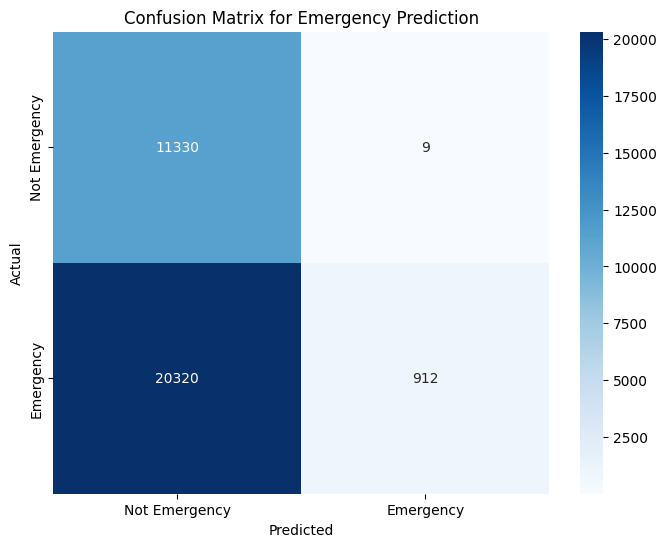


Evaluation for importance prediction:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17122
           1       1.00      1.00      1.00     15449

    accuracy                           1.00     32571
   macro avg       1.00      1.00      1.00     32571
weighted avg       1.00      1.00      1.00     32571

Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


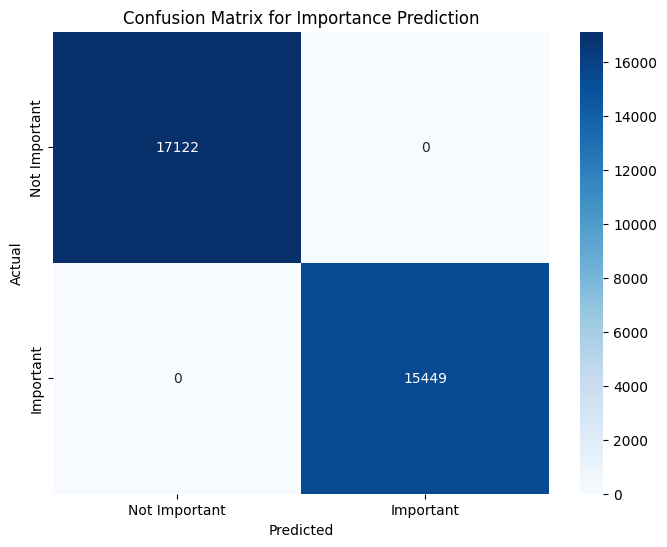


Evaluation for 3-class priority prediction:
              precision    recall  f1-score   support

           1       1.00      0.00      0.01     15449
           2       0.99      0.14      0.25      5783
           3       0.36      1.00      0.53     11339

    accuracy                           0.38     32571
   macro avg       0.78      0.38      0.26     32571
weighted avg       0.77      0.38      0.23     32571



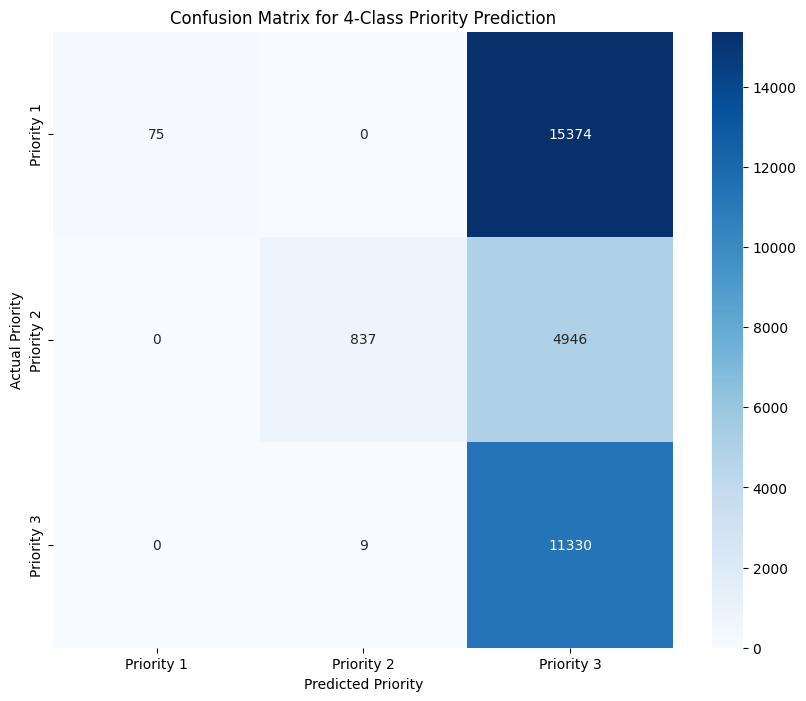

In [31]:
    #def evaluate_imbalanced_models(emergency_model, important_model, X_test, y_test):
    """
    Evaluate models trained on imbalanced data with appropriate metrics
    """
    # Predict with each model
    emergency_pred = emergency_model.predict(X_test)
    important_pred = important_model.predict(X_test)

    # Evaluate emergency prediction
    print("\nEvaluation for emergency prediction:")
    print(classification_report(y_test['is_emergency'], emergency_pred))

    # Special metrics for imbalanced data
    precision, recall, f1, _ = precision_recall_fscore_support(y_test['is_emergency'], emergency_pred, average='binary')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Create confusion matrix
    cm = confusion_matrix(y_test['is_emergency'], emergency_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Emergency', 'Emergency'],
               yticklabels=['Not Emergency', 'Emergency'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Emergency Prediction')
    plt.show()

    # Evaluate importance prediction
    print("\nEvaluation for importance prediction:")
    print(classification_report(y_test['is_important'], important_pred))

    # Special metrics for imbalanced data
    precision, recall, f1, _ = precision_recall_fscore_support(y_test['is_important'], important_pred, average='binary')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Create confusion matrix
    cm = confusion_matrix(y_test['is_important'], important_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Important', 'Important'],
               yticklabels=['Not Important', 'Important'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Importance Prediction')
    plt.show()

    # Calculate the 4-class priority
    #LHM Calculate the 3-class priority
    y_test_combined = y_test.copy()
    y_test_combined['pred_emergency'] = emergency_pred
    y_test_combined['pred_important'] = important_pred

    y_test_combined['true_priority'] = 3  # Default: Not Emergency and Not Important
    y_test_combined.loc[(y_test_combined['is_emergency'] == 1) & (y_test_combined['is_important'] == 1), 'true_priority'] = 1
    y_test_combined.loc[(y_test_combined['is_emergency'] == 1) & (y_test_combined['is_important'] == 0), 'true_priority'] = 2
    #y_test_combined.loc[(y_test_combined['is_emergency'] == 0) & (y_test_combined['is_important'] == 1), 'true_priority'] = 3

    y_test_combined['pred_priority'] = 3  # Default: Not Emergency and Not Important
    y_test_combined.loc[(y_test_combined['pred_emergency'] == 1) & (y_test_combined['pred_important'] == 1), 'pred_priority'] = 1
    y_test_combined.loc[(y_test_combined['pred_emergency'] == 1) & (y_test_combined['pred_important'] == 0), 'pred_priority'] = 2
     # y_test_combined.loc[(y_test_combined['pred_emergency'] == 0) & (y_test_combined['pred_important'] == 1), 'pred_priority'] = 3

    """
    y_test_combined['true_priority'] = 4  # Default: Not Emergency and Not Important
    y_test_combined.loc[(y_test_combined['is_emergency'] == 1) & (y_test_combined['is_important'] == 1), 'true_priority'] = 1
    y_test_combined.loc[(y_test_combined['is_emergency'] == 1) & (y_test_combined['is_important'] == 0), 'true_priority'] = 2
    y_test_combined.loc[(y_test_combined['is_emergency'] == 0) & (y_test_combined['is_important'] == 1), 'true_priority'] = 3

    y_test_combined['pred_priority'] = 4  # Default: Not Emergency and Not Important
    y_test_combined.loc[(y_test_combined['pred_emergency'] == 1) & (y_test_combined['pred_important'] == 1), 'pred_priority'] = 1
    y_test_combined.loc[(y_test_combined['pred_emergency'] == 1) & (y_test_combined['pred_important'] == 0), 'pred_priority'] = 2
    y_test_combined.loc[(y_test_combined['pred_emergency'] == 0) & (y_test_combined['pred_important'] == 1), 'pred_priority'] = 3
    """


    # Calculate metrics for the 4-class problem
    print("\nEvaluation for 3-class priority prediction:")
    #LHM print("\nEvaluation for 4-class priority prediction:")
    print(classification_report(y_test_combined['true_priority'], y_test_combined['pred_priority']))

    # Create confusion matrix for the 4-class problem
    cm = confusion_matrix(y_test_combined['true_priority'], y_test_combined['pred_priority'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Priority 1', 'Priority 2', 'Priority 3'],
               yticklabels=['Priority 1', 'Priority 2', 'Priority 3'])
    """ LHM
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Priority 1', 'Priority 2', 'Priority 3', 'Priority 4'],
               yticklabels=['Priority 1', 'Priority 2', 'Priority 3', 'Priority 4'])
               """
    plt.xlabel('Predicted Priority')
    plt.ylabel('Actual Priority')
    plt.title('Confusion Matrix for 4-Class Priority Prediction')
    plt.show()







In [32]:

    # Step 7: Make predictions on new data (in a real scenario)
    print("\nStep 7: Demonstrating prediction on new data...")
    # For demonstration, we'll use a small subset of the test data as "new" data
    new_data = X_test.iloc[:5].copy()
    #def predict_with_imbalanced_models(emergency_model, important_model, new_data, numerical_features):
    """
    Use the trained models to predict priority for new network traffic
    """
    # Preprocess the new data
    X_new = new_data[numerical_features]

    # Make predictions with both models
    emergency_pred = emergency_model.predict(X_new)
    important_pred = important_model.predict(X_new)

    # Combine predictions
    pred_df = pd.DataFrame({
        'emergency': emergency_pred,
        'important': important_pred
    })

    # Map to priority classes
    pred_df['priority_class'] = 4  # Default: Not Emergency and Not Important
    pred_df.loc[(pred_df['emergency'] == 1) & (pred_df['important'] == 1), 'priority_class'] = 1
    pred_df.loc[(pred_df['emergency'] == 1) & (pred_df['important'] == 0), 'priority_class'] = 2
    pred_df.loc[(pred_df['emergency'] == 0) & (pred_df['important'] == 1), 'priority_class'] = 3

    # Map to priority labels
    priority_labels = {
        1: "Emergency and Important (highest priority)",
        2: "Emergency but Not Important",
        3: "Not Emergency but Important",
        4: "Not Emergency and Not Important (lowest priority)"
    }

    pred_df['priority_label'] = pred_df['priority_class'].map(priority_labels)

    # Combine with original data
    result = pd.concat([new_data.reset_index(drop=True), pred_df], axis=1)
    print("\nSample predictions:")
    print(result[['priority_class', 'priority_label']])
    print("\nModel training and evaluation completed successfully.")
    #return result



Step 7: Demonstrating prediction on new data...

Sample predictions:
   priority_class                                     priority_label
0               4  Not Emergency and Not Important (lowest priority)
1               4  Not Emergency and Not Important (lowest priority)
2               4  Not Emergency and Not Important (lowest priority)
3               4  Not Emergency and Not Important (lowest priority)
4               3                        Not Emergency but Important

Model training and evaluation completed successfully.
